```
From: https://github.com/ksatola
Version: 0.1.0
```

# Model - Prepare Analytical Views For Modelling

We will prepare the data for:
- statistical modeling (without any transformations),
- machine learning analysis by creating lagged variables.

The data will be adjusted for the following kinds of forecasts:
- Next 24 hours (hourly data),
- Next 7 days forecast (daily data).

We will then save these new dataframes.

## Contents

- [Load PM2.5 and PM10 Analytical View From a CSV File](#data_csv_pm25)
- [**Statistical Models**: Build PM2.5 HDF Analytical View Representation File](#data_hdf_pm25)
- [Data-related feature engineering](#feature_pm25_ml)
- [**Machine Learning Models**: Build PM2.5 HDF Analytical View Representation File](#data_hdf_pm25_ml)

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../src')

In [4]:
import pandas as pd 
import numpy as np

In [5]:
from model import (
    load_data,
    calculate_season,
    build_datetime_features
)

from plot import (
    plot_ts_corr,
    plot_stl
)

from stats import (
    adfuller_test
)

In [6]:
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('precision', 5)

In [7]:
data_path = 'data/'
data_file = data_path + 'dfpm2008_2018.csv'

---
<a id='#data_csv_pm25'></a>

## Load PM2.5 and PM10 Analytical View From a CSV File

In [8]:
df = load_data(data_file)

common.py | 14 | load_data | 03-Jun-20 01:00:16 | INFO: Dataframe loaded: data/dfpm2008_2018.csv
common.py | 15 | load_data | 03-Jun-20 01:00:16 | INFO: DataFrame size: (96388, 2)


---
<a id='##data_hdf_pm25'></a>

## Build PM2.5 HDF Analytical View Representation File

In [9]:
df.index

Index(['2008-01-01 01:00:00', '2008-01-01 02:00:00', '2008-01-01 03:00:00',
       '2008-01-01 04:00:00', '2008-01-01 05:00:00', '2008-01-01 06:00:00',
       '2008-01-01 07:00:00', '2008-01-01 08:00:00', '2008-01-01 09:00:00',
       '2008-01-01 10:00:00',
       ...
       '2018-12-31 15:00:00.000', '2018-12-31 16:00:00.000',
       '2018-12-31 17:00:00.000', '2018-12-31 18:00:00.000',
       '2018-12-31 19:00:00.000', '2018-12-31 20:00:00.000',
       '2018-12-31 21:00:00.000', '2018-12-31 22:00:00.000',
       '2018-12-31 23:00:00.000', '2019-01-01 00:00:00.000'],
      dtype='object', name='Datetime', length=96388)

### Set the index type to datetime to be able to perform time-related operations

In [10]:
# Convert index to datetime with minutes frequency
df.index = pd.to_datetime(df.index)

In [11]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
df.asfreq('T').index

DatetimeIndex(['2008-01-01 01:00:00', '2008-01-01 01:01:00',
               '2008-01-01 01:02:00', '2008-01-01 01:03:00',
               '2008-01-01 01:04:00', '2008-01-01 01:05:00',
               '2008-01-01 01:06:00', '2008-01-01 01:07:00',
               '2008-01-01 01:08:00', '2008-01-01 01:09:00',
               ...
               '2018-12-31 23:51:00', '2018-12-31 23:52:00',
               '2018-12-31 23:53:00', '2018-12-31 23:54:00',
               '2018-12-31 23:55:00', '2018-12-31 23:56:00',
               '2018-12-31 23:57:00', '2018-12-31 23:58:00',
               '2018-12-31 23:59:00', '2019-01-01 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=5785861, freq='T')

In [12]:
df.head()

,pm10,pm25
Datetime,,
2008-01-01 01:00:00,109.5,92.0
2008-01-01 02:00:00,96.0,81.0
2008-01-01 03:00:00,86.5,73.0
2008-01-01 04:00:00,71.5,60.5
2008-01-01 05:00:00,72.0,61.0


In [13]:
# We will only need PM2.5 for modelling
df.drop(columns=['pm10'], axis='columns', inplace=True) # axis=1
df.head()

,pm25
Datetime,
2008-01-01 01:00:00,92.0
2008-01-01 02:00:00,81.0
2008-01-01 03:00:00,73.0
2008-01-01 04:00:00,60.5
2008-01-01 05:00:00,61.0


### Dataset - Hourly Frequency

In [14]:
data_file_hdf = data_path + 'dfpm25_2008-2018_hourly.hdf'
df.to_hdf(data_file_hdf, key='df', mode='w')

### Test Read

In [15]:
df = pd.read_hdf(path_or_buf=data_file_hdf, key="df")
print(f'Dataframe size: {df.shape}')
df.head()

Dataframe size: (96388, 1)


,pm25
Datetime,
2008-01-01 01:00:00,92.0
2008-01-01 02:00:00,81.0
2008-01-01 03:00:00,73.0
2008-01-01 04:00:00,60.5
2008-01-01 05:00:00,61.0


### Dataset - Daily Frequency

In [16]:
# Resample data to daily using mean of values
df_daily = df.resample(rule='D').mean() # daily
df_daily.head()

,pm25
Datetime,
2008-01-01,53.58696
2008-01-02,30.95833
2008-01-03,46.10417
2008-01-04,42.97917
2008-01-05,57.31250


In [17]:
data_file_hdf = data_path + 'dfpm25_2008-2018_daily.hdf'
df_daily.to_hdf(data_file_hdf, key='df', mode='w')

### Test Read

In [18]:
df = pd.read_hdf(path_or_buf=data_file_hdf, key="df")
print(f'Dataframe size: {df.shape}')
df.head()

Dataframe size: (4019, 1)


,pm25
Datetime,
2008-01-01,53.58696
2008-01-02,30.95833
2008-01-03,46.10417
2008-01-04,42.97917
2008-01-05,57.31250


---
<a id='#feature_pm25_ml'></a>

## Data-related feature engineering

`Feature engineering` is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data. For machine learning models, instead of dealing with datetime index, we will create `additional features based on time` and include them in the analytical view. In addition, we will perform `time series data decomposition` (remove trend and seasonality) and check ACF for most correlated lags to be chosen as features. In the final prediction mechanism, the predicted values on stationary component can be transform to the original values by adding removed earlier trend and seasonality components.

---
<a id='#data_hdf_pm25_ml'></a>

## Machine Learning Models: Build PM2.5 HDF Analytical View Representation File

In [19]:
df = load_data(data_file)

common.py | 14 | load_data | 03-Jun-20 01:00:24 | INFO: Dataframe loaded: data/dfpm2008_2018.csv
common.py | 15 | load_data | 03-Jun-20 01:00:24 | INFO: DataFrame size: (96388, 2)


In [20]:
# We will only need PM2.5 for ML modelling
df.drop(columns=['pm10'], axis='columns', inplace=True) # axis=1
df.head()

,pm25
Datetime,
2008-01-01 01:00:00,92.0
2008-01-01 02:00:00,81.0
2008-01-01 03:00:00,73.0
2008-01-01 04:00:00,60.5
2008-01-01 05:00:00,61.0


### Create Lagged Variables - Hourly

### Get time series residuals for modelling

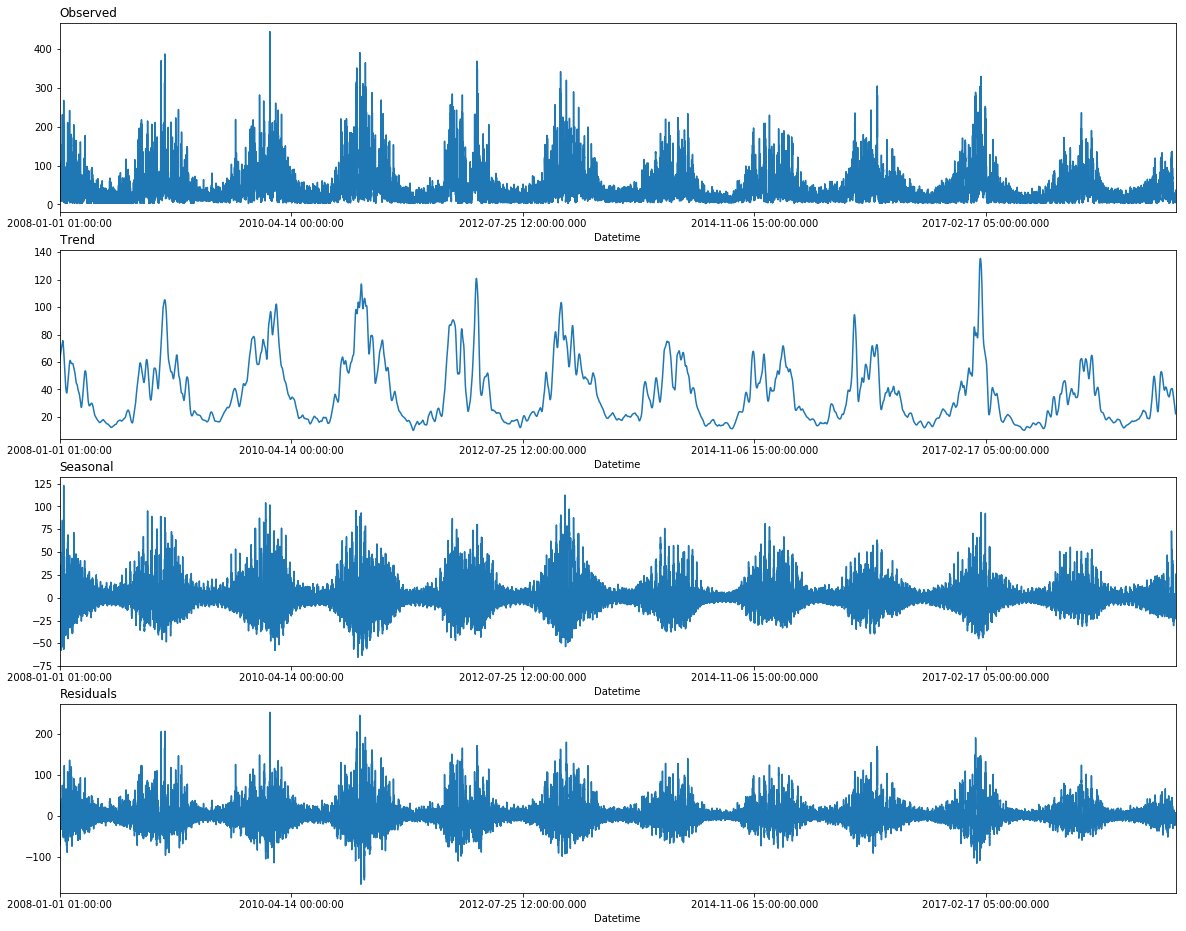

In [21]:
# Decompose time series
decomposed_df = plot_stl(data=df['pm25'], period=365, low_pass=367)

In [22]:
# Check for stationarity
adfuller_test(decomposed_df.resid)

Test statistic: -34.39472832921283
P-value: 0.0 -> 0.0000000000000000
Critical values: {'1%': -3.4304178932130585, '5%': -2.8615700077238575, '10%': -2.5667859720635713}
The time series does not have a unit root, so it is stationary (reject H0)


In [23]:
df = decomposed_df.resid.to_frame()
df.columns = ['pm25']
df.head()

,pm25
Datetime,
2008-01-01 01:00:00,28.53780
2008-01-01 02:00:00,23.61171
2008-01-01 03:00:00,20.93616
2008-01-01 04:00:00,14.01914
2008-01-01 05:00:00,14.16381


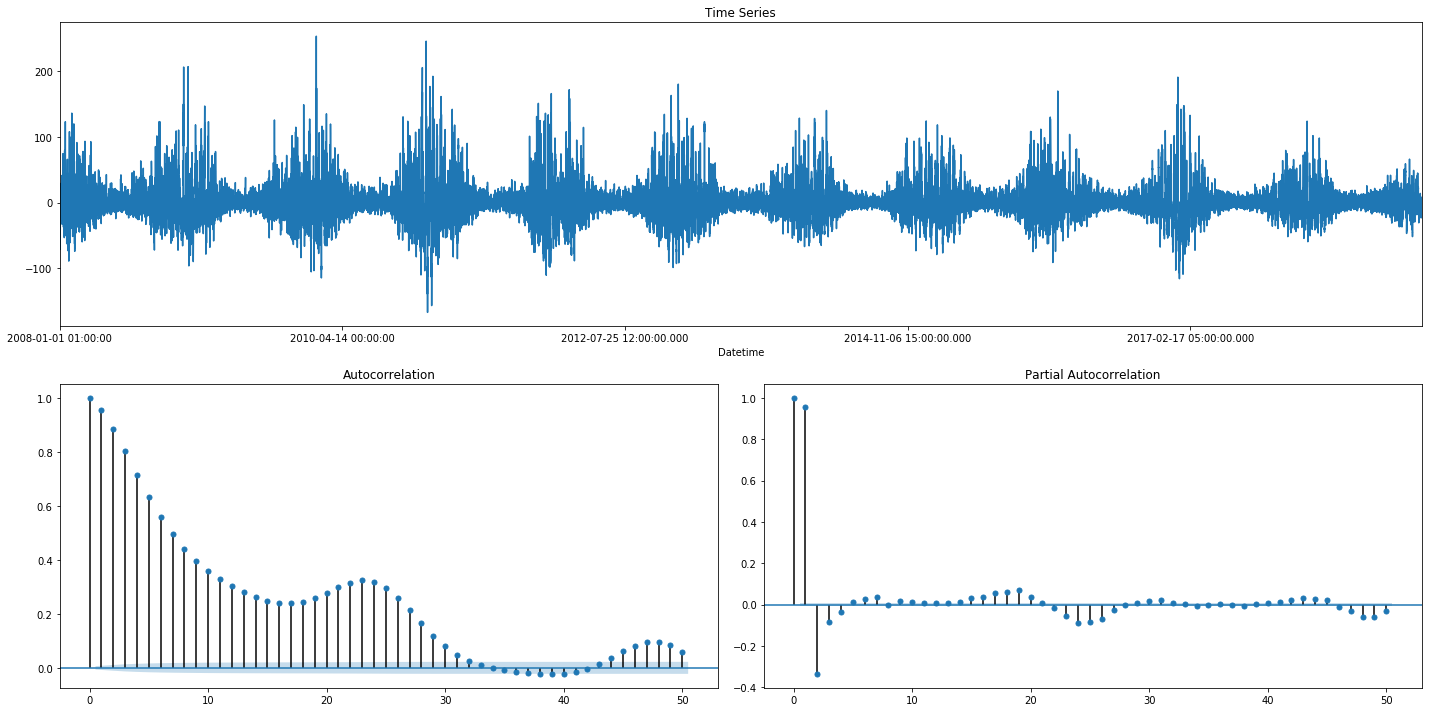

In [24]:
plot_ts_corr(df['pm25'])

In [ ]:
# There is a function for that:

In [25]:
# Create 10 hours of lag values to predict current observation (correlation coefficient > 0.4)
df24h = pd.DataFrame()

lags = 10

# Create column t
df24h['t'] = df['pm25']

for i in range(1, lags+1):
    df24h[['t-'+str(i)]] = df.shift(i)

df24h.head(lags+1)

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
Datetime,,,,,,,,,,,
2008-01-01 01:00:00,28.53780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 02:00:00,23.61171,28.53780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 03:00:00,20.93616,23.61171,28.53780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 04:00:00,14.01914,20.93616,23.61171,28.53780,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 05:00:00,14.16381,14.01914,20.93616,23.61171,28.53780,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 06:00:00,13.45617,14.16381,14.01914,20.93616,23.61171,28.53780,NaN,NaN,NaN,NaN,NaN
2008-01-01 07:00:00,10.13691,13.45617,14.16381,14.01914,20.93616,23.61171,28.53780,NaN,NaN,NaN,NaN
2008-01-01 08:00:00,9.91560,10.13691,13.45617,14.16381,14.01914,20.93616,23.61171,28.53780,NaN,NaN,NaN
2008-01-01 09:00:00,0.15650,9.91560,10.13691,13.45617,14.16381,14.01914,20.93616,23.61171,28.53780,NaN,NaN


In [26]:
# Remove NaNs
df24h = df24h.iloc[lags:]
df24h.head()

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
Datetime,,,,,,,,,,,
2008-01-01 11:00:00,-18.24617,-13.44392,0.15650,9.91560,10.13691,13.45617,14.16381,14.01914,20.93616,23.61171,28.53780
2008-01-01 12:00:00,-25.83965,-18.24617,-13.44392,0.15650,9.91560,10.13691,13.45617,14.16381,14.01914,20.93616,23.61171
2008-01-01 13:00:00,-16.76182,-25.83965,-18.24617,-13.44392,0.15650,9.91560,10.13691,13.45617,14.16381,14.01914,20.93616
2008-01-01 14:00:00,-6.69730,-16.76182,-25.83965,-18.24617,-13.44392,0.15650,9.91560,10.13691,13.45617,14.16381,14.01914
2008-01-01 15:00:00,-2.51557,-6.69730,-16.76182,-25.83965,-18.24617,-13.44392,0.15650,9.91560,10.13691,13.45617,14.16381


In [27]:
# Remove Datetime index and calculate date-related features from it
df24h = build_datetime_features(df24h, 'Datetime')
df24h.head()

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,month,day,hour,dayofyear,weekofyear,dayofweek,quarter,season
0,-18.24617,-13.44392,0.15650,9.91560,10.13691,13.45617,14.16381,14.01914,20.93616,23.61171,28.53780,1,1,11,1,1,1,1,1
1,-25.83965,-18.24617,-13.44392,0.15650,9.91560,10.13691,13.45617,14.16381,14.01914,20.93616,23.61171,1,1,12,1,1,1,1,1
2,-16.76182,-25.83965,-18.24617,-13.44392,0.15650,9.91560,10.13691,13.45617,14.16381,14.01914,20.93616,1,1,13,1,1,1,1,1
3,-6.69730,-16.76182,-25.83965,-18.24617,-13.44392,0.15650,9.91560,10.13691,13.45617,14.16381,14.01914,1,1,14,1,1,1,1,1
4,-2.51557,-6.69730,-16.76182,-25.83965,-18.24617,-13.44392,0.15650,9.91560,10.13691,13.45617,14.16381,1,1,15,1,1,1,1,1


In [28]:
data_file_hdf = data_path + 'dfpm25_2008-2018_ml_24hours_lags.hdf'
df24h.to_hdf(data_file_hdf, key='df', mode='w')

### Test Read

In [29]:
df24h = pd.read_hdf(path_or_buf=data_file_hdf, key="df")
print(f'Dataframe size: {df.shape}')
df24h.head()

Dataframe size: (96388, 1)


,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,month,day,hour,dayofyear,weekofyear,dayofweek,quarter,season
0,-18.24617,-13.44392,0.15650,9.91560,10.13691,13.45617,14.16381,14.01914,20.93616,23.61171,28.53780,1,1,11,1,1,1,1,1
1,-25.83965,-18.24617,-13.44392,0.15650,9.91560,10.13691,13.45617,14.16381,14.01914,20.93616,23.61171,1,1,12,1,1,1,1,1
2,-16.76182,-25.83965,-18.24617,-13.44392,0.15650,9.91560,10.13691,13.45617,14.16381,14.01914,20.93616,1,1,13,1,1,1,1,1
3,-6.69730,-16.76182,-25.83965,-18.24617,-13.44392,0.15650,9.91560,10.13691,13.45617,14.16381,14.01914,1,1,14,1,1,1,1,1
4,-2.51557,-6.69730,-16.76182,-25.83965,-18.24617,-13.44392,0.15650,9.91560,10.13691,13.45617,14.16381,1,1,15,1,1,1,1,1


### Create Lagged Variables - Daily

In [30]:
# Convert index to datetime with minutes frequency
df.index = pd.to_datetime(df.index)

# Resample data to daily using mean of values
df_daily = df[['pm25']].resample(rule='D').mean() # daily
df_daily.head()

,pm25
Datetime,
2008-01-01,4.86838
2008-01-02,-35.67099
2008-01-03,-8.19009
2008-01-04,9.00508
2008-01-05,11.55461


### Get time series residuals for modelling

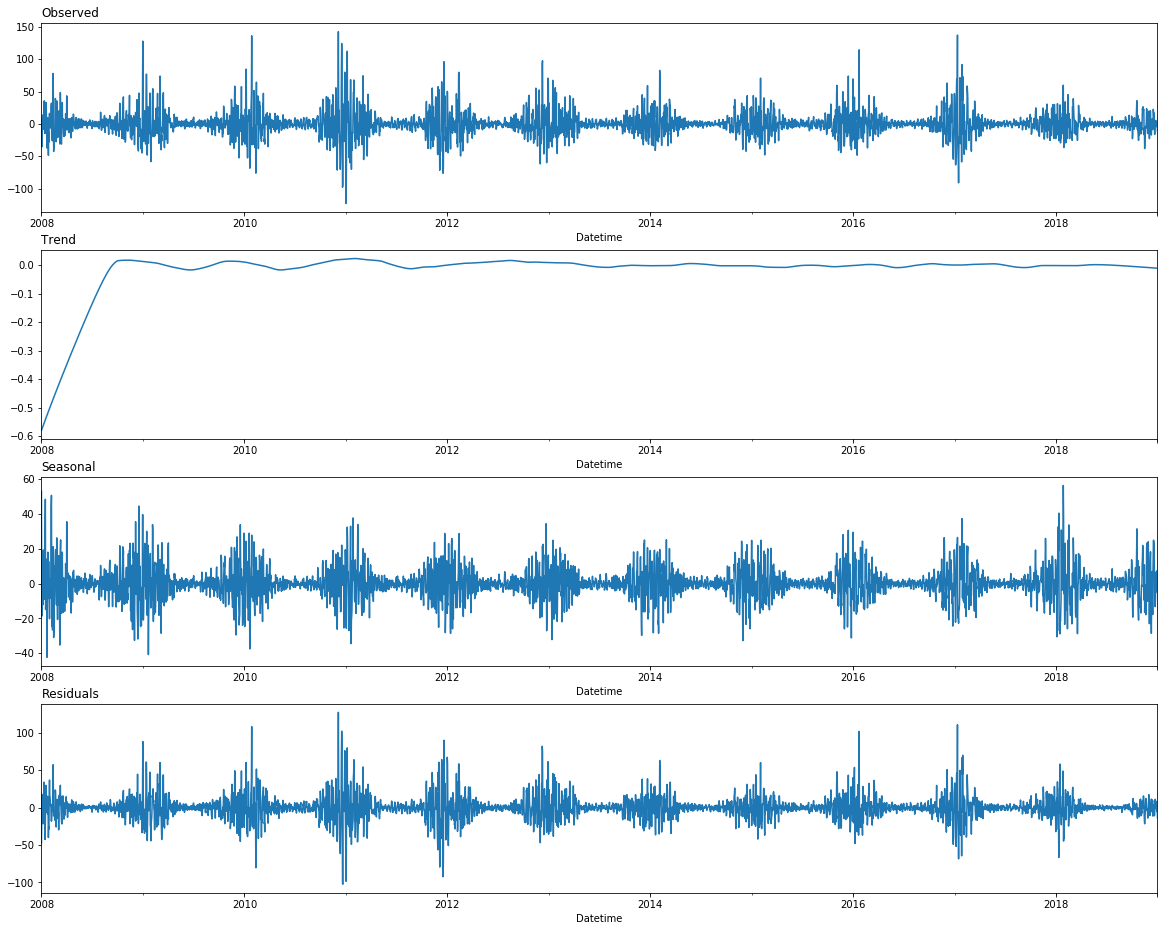

In [31]:
# Decompose time series
decomposed_df = plot_stl(data=df_daily['pm25'], period=365, low_pass=367)

In [32]:
# Check for stationarity
adfuller_test(decomposed_df.resid)

Test statistic: -19.241236457633008
P-value: 0.0 -> 0.0000000000000000
Critical values: {'1%': -3.4319912127364143, '5%': -2.8622651980110834, '10%': -2.567156030734827}
The time series does not have a unit root, so it is stationary (reject H0)


In [33]:
df_daily = decomposed_df.resid.to_frame()
df_daily.columns = ['pm25']
df_daily.head()

,pm25
Datetime,
2008-01-01,-47.64517
2008-01-02,-16.37491
2008-01-03,5.13497
2008-01-04,17.62891
2008-01-05,7.38135


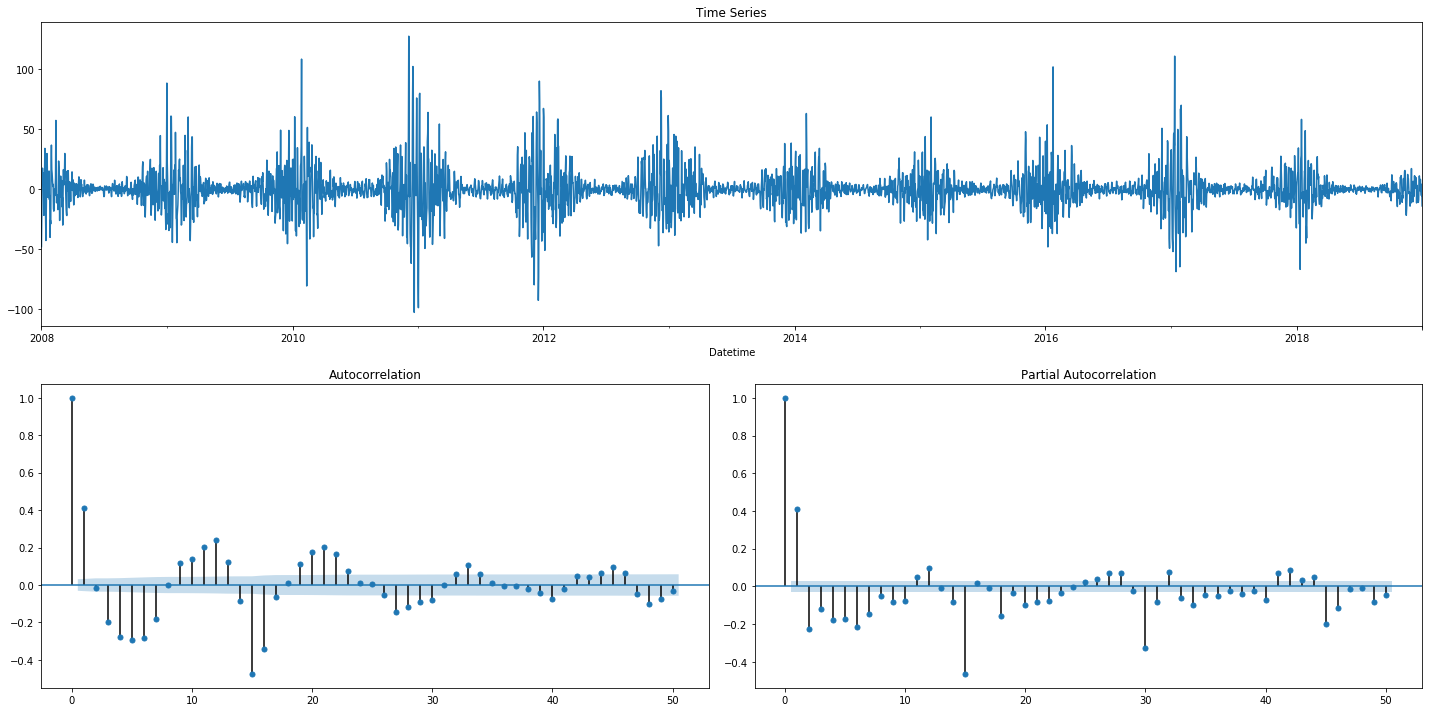

In [34]:
plot_ts_corr(df_daily['pm25'])

In [35]:
# Create 5 days of lag values to predict current observation (and remove lag2)
df7d = pd.DataFrame()

lags = 5

# Create column t
df7d['t'] = df_daily['pm25']

for i in range(1, lags+1):
    df7d[['t-'+str(i)]] = df_daily.shift(i)
    
df7d = df7d.drop(['t-2'], axis=1)

df7d.head(lags+1)

,t,t-1,t-3,t-4,t-5
Datetime,,,,,
2008-01-01,-47.64517,NaN,NaN,NaN,NaN
2008-01-02,-16.37491,-47.64517,NaN,NaN,NaN
2008-01-03,5.13497,-16.37491,NaN,NaN,NaN
2008-01-04,17.62891,5.13497,-47.64517,NaN,NaN
2008-01-05,7.38135,17.62891,-16.37491,-47.64517,NaN
2008-01-06,4.29082,7.38135,5.13497,-16.37491,-47.64517


In [36]:
# Remove NaNs
df7d = df7d.iloc[lags:]
df7d.head()

,t,t-1,t-3,t-4,t-5
Datetime,,,,,
2008-01-06,4.29082,7.38135,5.13497,-16.37491,-47.64517
2008-01-07,13.62581,4.29082,17.62891,5.13497,-16.37491
2008-01-08,-21.62104,13.62581,7.38135,17.62891,5.13497
2008-01-09,8.67829,-21.62104,4.29082,7.38135,17.62891
2008-01-10,11.64189,8.67829,13.62581,4.29082,7.38135


In [37]:
# Remove Datetime index and calculate date-related features from it
df7d = build_datetime_features(df7d, 'Datetime')
df7d.head()

,t,t-1,t-3,t-4,t-5,month,day,hour,dayofyear,weekofyear,dayofweek,quarter,season
0,4.29082,7.38135,5.13497,-16.37491,-47.64517,1,6,0,6,1,6,1,1
1,13.62581,4.29082,17.62891,5.13497,-16.37491,1,7,0,7,2,0,1,1
2,-21.62104,13.62581,7.38135,17.62891,5.13497,1,8,0,8,2,1,1,1
3,8.67829,-21.62104,4.29082,7.38135,17.62891,1,9,0,9,2,2,1,1
4,11.64189,8.67829,13.62581,4.29082,7.38135,1,10,0,10,2,3,1,1


In [38]:
data_file_hdf = data_path + 'dfpm25_2008-2018_ml_7days_lags.hdf'
df7d.to_hdf(data_file_hdf, key='df', mode='w')

### Test Read

In [39]:
df7d = pd.read_hdf(path_or_buf=data_file_hdf, key="df")
print(f'Dataframe size: {df.shape}')
df7d.head()

Dataframe size: (96388, 1)


,t,t-1,t-3,t-4,t-5,month,day,hour,dayofyear,weekofyear,dayofweek,quarter,season
0,4.29082,7.38135,5.13497,-16.37491,-47.64517,1,6,0,6,1,6,1,1
1,13.62581,4.29082,17.62891,5.13497,-16.37491,1,7,0,7,2,0,1,1
2,-21.62104,13.62581,7.38135,17.62891,5.13497,1,8,0,8,2,1,1,1
3,8.67829,-21.62104,4.29082,7.38135,17.62891,1,9,0,9,2,2,1,1
4,11.64189,8.67829,13.62581,4.29082,7.38135,1,10,0,10,2,3,1,1
